In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook
from IPython import display
import matplotlib.pyplot as plt

In [2]:
#Load data
train = np.load('adult/adult_train.npz')
test = np.load('adult/adult_test.npz')

In [3]:
header = np.loadtxt('adult/adult_headers.txt', dtype=str)

In [4]:
data_train_x = pd.DataFrame(data=train['x'], columns=header[:-1])
data_train_y = pd.DataFrame(data=train['y'], columns= ['income'])
data_train_a = pd.DataFrame(data=train['a'], columns=['gender'])

In [5]:
data_test_x = pd.DataFrame(data=test['x'], columns=header[:-1])
data_test_y = pd.DataFrame(data=test['y'], columns= ['income'])
data_test_a = pd.DataFrame(data=test['a'], columns=['gender'])

In [6]:
data_train = pd.concat([data_train_y, data_train_a, data_train_x], axis=1)

In [7]:
data_test = pd.concat([data_test_y, data_test_a, data_test_x], axis=1)

# Question 2

## 1.

In [8]:
## Ten most correlated features with Y
corr_with_Y = data_train[data_train.columns.difference(['gender'])].corr()['income'].abs().nlargest(11).index[1:]
corr_with_Y

Index(['marital-status_Married-civ-spouse', 'relationship_Husband',
       'education_num', 'marital-status_Never-married', 'age_u30',
       'hours-per-week', 'relationship_Own-child', 'capital-gain',
       'sex_Female', 'sex_Male'],
      dtype='object')

In [9]:
## Ten most correlated features with A
corr_with_A = data_train[data_train.columns.difference(['income'])].corr()['gender'].abs().nlargest(11).index[1:]
corr_with_A

Index(['sex_Female', 'sex_Male', 'relationship_Husband',
       'marital-status_Married-civ-spouse', 'relationship_Unmarried',
       'relationship_Wife', 'occupation_Adm-clerical', 'hours-per-week',
       'marital-status_Divorced', 'occupation_Craft-repair'],
      dtype='object')

## 2.

In [10]:
#Model definition
class Classifier(nn.Module): 
  
    def __init__(self, input_size, num_classes): 
        super(Classifier, self).__init__() 
        self.input_size = input_size
        self.linear1 = nn.Linear(input_size, 100)
        self.linear2 = nn.Linear(100, 100)
        self.linear3 = nn.Linear(100, num_classes)
                                
    def forward(self, x): 
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [11]:
# Classifier, training and metrics
class QuestionTwo():
    def __init__(self, model, Data_train, Epoch, Criterion):
        self.data_train = Data_train
        self.epoch = Epoch
        self.model = model
        self.criterion = Criterion

    def create_dataloader(self, Data, batch=32):
        assert (type(Data) == pd.core.frame.DataFrame)
        assert ('income' and 'gender' in Data.columns)
        X = torch.from_numpy(Data[Data.columns.difference(['income', 'gender'])].values).float()
        y = torch.from_numpy(Data['income'].values.ravel())
        a = torch.from_numpy(Data['gender'].values.ravel())
        
        tensor_data = TensorDataset(X, y, a)
        tensor_loader = DataLoader(tensor_data, batch_size=batch)
        return tensor_loader
        
    def train(self):
        train_loader = self.create_dataloader(self.data_train)
        self.model.train()
        for epoch in range(self.epoch):
            for X, y, a in train_loader:
                outputs = self.model(X)
                loss = self.criterion(outputs.squeeze(), y.float())
                #predicted = (outputs.squeeze() > 0.).long()
                model.zero_grad()
                loss.backward()
                optimizer.step()
            
            display.clear_output(wait=True)
            print(" Epoch: %i / %i, loss = %.6f " %((epoch+1), self.epoch, loss.item()))
    def get_full_data(self, Data):
        full_data = dict()
        Data_new = Data.drop(['income','gender'], axis=1)
        full_data['X'] = torch.from_numpy(Data_new.values)
        full_data['y'] = torch.from_numpy(Data['income'].values)
        full_data['a'] = torch.from_numpy(Data['gender'].values)
        
        return full_data
    
    def predict(self, Data):
        data_loader = self.create_dataloader(Data)
        self.model.eval()
        predictions = []
        for X, y, a in tqdm_notebook(data_loader):
            outputs = self.model(X)
            predictions.append((outputs.squeeze() > 0.).long())
        return torch.cat(predictions, dim=0)
    
    def accuracy(self, Data, accuracy_of):
        if accuracy_of not in ['y', 'a']:
            raise Exception('Accuracy must be calculated for either y or a')
        predict = self.predict(Data)
        full_data = self.get_full_data(Data)
        return predict.eq(full_data[accuracy_of].long()).float().sum().item() / predict.size(0)
        
    def reweighted_accuracy(self, Data, accuracy_of, according_to):
        if accuracy_of not in ['y', 'a']:
            raise Exception('Accuracy must be calculated for either y or a')
        if according_to != 'a':
            raise Exception('Accuracy must be calculated according to attribute a')
        predict = self.predict(Data)
        full_data = self.get_full_data(Data)
        attribute = full_data[according_to].float()
        target = full_data[accuracy_of]#.float()
        compare = predict.eq(target.long()).float()
        sens_attrib_0 = torch.where(attribute == 0., \
                                    compare, torch.zeros_like(attribute)).sum().item()
        sens_attrib_1 = torch.where(attribute == 1., \
                                    compare, torch.zeros_like(attribute)).sum().item()
        na_0 = (attribute == 0).sum().item()
        na_1 = (attribute == 1).sum().item()
        
        return 0.5 * ( (sens_attrib_0 / na_0) + (sens_attrib_1 / na_1) )
        
    def fairness_metric(self, Data, groups=False):
        predict = self.predict(Data)
        full_data = self.get_full_data(Data)
        attribute = full_data['a'].float()

        rs = (predict * (1 - attribute.long())).sum().item()
        ls = (predict * attribute.long()).sum().item()
        na_0 = (attribute == 0).sum().item()
        na_1 = (attribute == 1).sum().item()
        if groups:
            return (np.abs((rs / na_0) - (ls / na_1)), (rs / na_0), (ls / na_1))
        else:
            return np.abs((rs / na_0) - (ls / na_1))
        

In [12]:
Epoch = 200
input_size = data_train[data_train.columns.difference(['income', 'gender'])].shape[1]
output_size = 1

In [13]:
criterion = nn.BCEWithLogitsLoss()
model = Classifier(input_size, output_size)

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

In [14]:
Neural_net = QuestionTwo(model, data_train, Epoch, criterion)

In [15]:
#Model training
Neural_net.train()

 Epoch: 200 / 200, loss = 0.263846 


In [16]:
# Test classification accuracy 
Neural_net.accuracy(data_test, accuracy_of='y')

0.8398132792825993

In [17]:
# Test disparity measure
Neural_net.fairness_metric(data_test)

0.14718227967562203

Create uncorrelated dataset

In [18]:
# Remove correlated features with A
data_train_uncorr = data_train[data_train.columns.difference(corr_with_A)]
data_test_uncorr = data_test[data_test.columns.difference(corr_with_A)]

In [19]:
Epoch = 200
input_size = data_train_uncorr[data_train_uncorr.columns.difference(['income', 'gender'])].shape[1]

In [20]:
model = Classifier(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)
Neural_net_corr = QuestionTwo(model, data_train_uncorr, Epoch, criterion)

In [21]:
# Model retraining
Neural_net_corr.train()

 Epoch: 200 / 200, loss = 0.275501 


In [22]:
# Accuracy
Neural_net_corr.accuracy(data_test_uncorr, accuracy_of='y')

0.8290645537743382

In [23]:
# Disparity measure
Neural_net_corr.fairness_metric(data_test_uncorr)

0.13424599037302246

In [24]:
# measure on each sensitive group
_, A0, A1 = Neural_net_corr.fairness_metric(data_test_uncorr, groups=True)

In [26]:
print('', A0, '\n', A1)

 0.1160302527209002 
 0.25027624309392266


## 3

In [27]:
yhat = Neural_net.predict(data_test)

In [28]:
corr_with_yhat = pd.concat([pd.DataFrame(yhat.data.numpy(), columns=['yhat']), data_test_x], axis=1).corr()['yhat'].abs().nlargest(4)
corr_with_yhat.index[1:]

Index(['capital-loss', 'education_num', 'marital-status_Married-civ-spouse'], dtype='object')

In [29]:
Examples = pd.concat([pd.DataFrame(yhat.data.numpy(), columns=['yhat']), data_test_a, data_test_x], axis=1).groupby(['gender']).corr().abs()['yhat']

In [30]:
Examples_A0 = Examples.unstack().loc[0].nlargest(4)
Examples_A0.index[1:]

Index(['capital-loss', 'relationship_Wife',
       'marital-status_Married-civ-spouse'],
      dtype='object')

In [31]:
Examples_A1 = Examples.unstack().loc[1].nlargest(4)
Examples_A1.index[1:]

Index(['education_num', 'capital-loss', 'relationship_Husband'], dtype='object')

## 4.

In [32]:
# sex_Male and sex_Female removed
data_train_reduced = data_train[data_train.columns.difference(['sex_Male', 'sex_Female'])]
data_test_reduced = data_test[data_test.columns.difference(['sex_Male', 'sex_Female'])]

In [33]:
input_size = data_train_reduced[data_train_reduced.columns.difference(['income', 'gender'])].shape[1]

In [34]:
model = Classifier(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)
Neural_net_reduced = QuestionTwo(model, data_train_reduced, Epoch, criterion)

In [35]:
# Training
Neural_net_reduced.train()

 Epoch: 200 / 200, loss = 0.270034 


In [36]:
ahat = Neural_net_reduced.predict(data_test_reduced)

In [37]:
# Accuracy
Neural_net_reduced.accuracy(data_test_reduced, 'a')

0.4579571279405442

In [38]:
# Reweighted accuracy
Neural_net_reduced.reweighted_accuracy(data_test_reduced, 'a', 'a')

0.5712424620439644

Without features correlated with A

In [39]:
# Accuracy on A
Neural_net_corr.accuracy(data_test_uncorr, 'a')

0.4612738775259505

In [40]:
# Reweighted accuracy on A
Neural_net_corr.reweighted_accuracy(data_test_uncorr, 'a', 'a')

0.5671229951865112

# Question 3

## 1.

In [41]:
from sklearn.mixture import GaussianMixture

In [42]:
# Preprocessing
def preprocess(data):
    
    gaus0 = GaussianMixture(n_components=1, covariance_type='diag')
    gaus1 = GaussianMixture(n_components=1, covariance_type='diag')
    
    data_y = data['income'].to_frame()
    data_a = data['gender'].to_frame()
    data_gaus = data.drop('income', axis=1)
    data_gaus_group = data_gaus.groupby(['gender'])
    
    gaus0.fit(data_gaus_group.get_group(0))
    gender_0 = data_gaus_group.get_group(0).pipe(lambda x: \
                                    (x - gaus0.means_) / np.sqrt(gaus0.covariances_))
    gaus1.fit(data_gaus_group.get_group(1))
    gender_1 = data_gaus_group.get_group(1).pipe(lambda x: \
                                    (x - gaus1.means_) / np.sqrt(gaus1.covariances_))
    data_normalize = pd.concat([gender_0, gender_1], axis=0)
    data_normalize.sort_index(inplace=True)
    data_normalize = data_normalize.drop('gender', axis=1)
    data_normalize = pd.concat([data_y, data_a, data_normalize], axis=1)
    
    return data_normalize


In [43]:
data_normalize_train = preprocess(data_train)
data_normalize_test = preprocess(data_test)

In [44]:
input_size = data_normalize_train[data_normalize_train.columns.difference(['income', 'gender'])].shape[1]
criterion = nn.BCEWithLogitsLoss()
model = Classifier(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

In [45]:
Neural_net_prep = QuestionTwo(model, data_normalize_train, Epoch, criterion)

In [46]:
Neural_net_prep.train()

 Epoch: 200 / 200, loss = 0.204399 


In [47]:
# Accuracy for g
Neural_net_prep.accuracy(data_normalize_test, 'y')

0.8509305325225723

In [48]:
# Demographic parity for g
Neural_net_prep.fairness_metric(data_normalize_test)

0.13823024028715827

In [49]:
# Accuracy for h
Neural_net_prep.accuracy(data_normalize_test, 'a')

0.4589398685584424

In [50]:
# Reweighted accuracy for h
Neural_net_prep.reweighted_accuracy(data_normalize_test, 'a', 'a')

0.5691151201435791

## 2.

In [52]:
from mmd import get_mmd_inds, MMD_torch

In [53]:
class Classifier(nn.Module): 
  
    def __init__(self, input_size, num_classes): 
        super(Classifier, self).__init__() 
        self.input_size = input_size
        self.linear1 = nn.Linear(input_size, 100)
        self.linear2 = nn.Linear(100, 32)
        self.linear3 = nn.Linear(32, num_classes)
                                
    def forward(self, x): 
        y_pred = F.relu(self.linear1(x))
        y_pred = self.linear2(y_pred)
        Z = y_pred
        y_pred = self.linear3(F.relu(y_pred))
        return (Z, y_pred) 

In [54]:
class QuestionThree(QuestionTwo):
    
    def train(self, alpha):
        train_loader = self.create_dataloader(self.data_train)
        for epoch in range(self.epoch):
            for X, y, a in train_loader:
                Z, outputs = model(X)
                loss = self.criterion(outputs.squeeze(), y.long()) + alpha * MMD_torch(Z, a)
                predicted = (outputs.squeeze() > 0.).long()
                model.zero_grad()
                loss.backward()
                optimizer.step()
            
            display.clear_output(wait=True)
            print(" Epoch: %i / %i, loss = %.6f " %((epoch+1), self.epoch, loss.item()))
            #print('Epoch', epoch, ':', 'loss =', loss.item())
    
    def predict(self, Data):
        data_loader = self.create_dataloader(Data)
        train_model = self.model.eval()
        predictions = []
        for X, y, a in tqdm_notebook(data_loader):
            Z, outputs = train_model(X)
            pred = outputs.argmax(dim=1, keepdim=False)
            predictions.append(pred)
        return torch.cat(predictions, dim=0)

In [55]:
output_size = 2
criterion = nn.CrossEntropyLoss()
model = Classifier(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

In [56]:
Neural_net_mmd = QuestionThree(model, data_normalize_train, Epoch, criterion)

In [57]:
Neural_net_mmd.train(0.1)

 Epoch: 200 / 200, loss = 0.219691 


In [58]:
# Accuracy of y
Neural_net_mmd.accuracy(data_normalize_test, 'y')

0.8524046434494196

In [59]:
# Demographic parity
Neural_net_mmd.fairness_metric(data_normalize_test)

0.14163693269778566

In [60]:
# Accuracy of a
Neural_net_mmd.accuracy(data_normalize_test, 'a')

0.4612738775259505

In [61]:
# Reweighted accuracy of a
Neural_net_mmd.reweighted_accuracy(data_normalize_test, 'a', 'a')

0.5708184663488929

In [62]:
alphas = np.linspace(0.001, 5, 20)

In [63]:
Epoch = 200
Neural_net_mmd = QuestionThree(model, data_normalize_train, Epoch, criterion)

In [64]:
accuracy_Y = np.zeros_like(alphas)
accuracy_A = np.zeros_like(alphas)
DP = np.zeros_like(alphas)
reweighted_accuacy = np.zeros_like(alphas)
for alpha in range(len(alphas)):
    Neural_net_mmd.train(alphas[alpha])
    accuracy_Y[alpha] = Neural_net_mmd.accuracy(data_normalize_test, 'y')
    accuracy_A[alpha] = Neural_net_mmd.accuracy(data_normalize_test, 'a')
    DP[alpha] = Neural_net_mmd.fairness_metric(data_normalize_test)
    reweighted_accuacy[alpha] = Neural_net_mmd.reweighted_accuracy(data_normalize_test, 'a', 'a')

 Epoch: 200 / 200, loss = 0.158675 


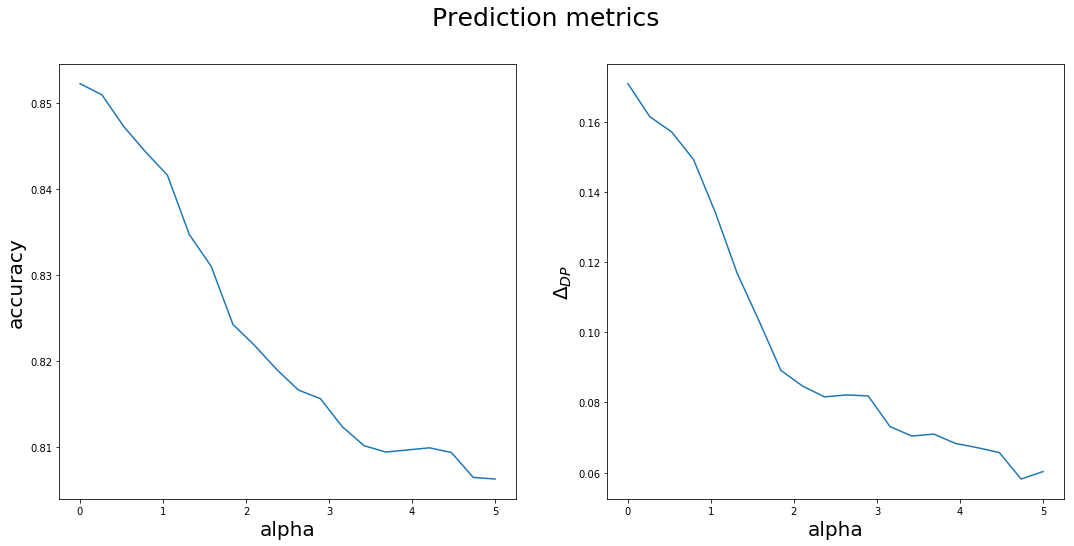

In [65]:
fig, ax = plt.subplots(1,2, figsize =(18,8))
ax[0].plot(alphas, accuracy_Y)
ax[0].set_ylabel('accuracy', fontsize=20)
ax[0].set_xlabel('alpha', fontsize=20)

ax[1].plot(alphas, DP)
ax[1].set_ylabel('$\\Delta_{DP}$', fontsize=20)
ax[1].set_xlabel('alpha', fontsize=20)

fig.suptitle('Prediction metrics', fontsize=25)
fig.savefig('prediction_plot.png')